# Neurodynamics Assignment (Honours)
(2019)

You need to analyze a research paper and to build a randomly connected excitatory-inhibitory neural network, as described in Brunel 00. Then you need to simulate the network model to reproduce the four different kinds of firing states as shown in Figure 8 of the paper.

When the network is around a balanced state, you need to add external perturbations to some neurons, investigating how the system responds to these perturbations.

For the students with good analytic skills, please fllow the mathematical analysis part of the paper. If  possible, develop new methods to analyze the stability of the differnt kinds of firing states.

N. Brunel, Dynamics of sparsely connected networks of excitatory and inhibitory neurons, Journal of Computational Neuroscience, 8:183-208 (2000).

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import time

In [2]:
#Define network parameters for model A: inhibitory and excitatory neurons have identical characteristics
N =  int(12500)#number of neurons
N_e = int(0.8*N) # number of excitatory neurons
N_i = int(0.2*N) # number of inhibitory neurons

C_e = int(1000) #4*C_i#number of connections each neuron receives from excitatory neurons
C_i = int(0.25*C_e) #number of connections each neuron receives from inhibitory neurons
C_ext = C_e #number of connections from outside the network

tau_e = 20e-3 #excitatory integration time constant
tau_rp = 2e-3 #refractory period (insensitive to stimulation)
theta = 20e-3 #firing threshold
V_r = 10e-3 #reset potential

g = np.array([3,6,5,4.5])#relative strength of inhibitory synapses
J = 0.1e-3 #postsynaptic potential (PSP) amplitude
D = 1.5e-3 # transmission delay
nu_extthr = np.array([2,4,2,0.9])#ratio of frequency of the external input to frequency that is needed for a 
            #neuron to reach threshold in absence of feedback
nu_thr = theta/(J*C_e*tau_e)

fig = 2
g_i = g[fig]
nu_ext = nu_extthr[fig]*nu_thr

In [3]:
deltat = 0.1e-3
totalt = 0.05
nsteps = int(np.round(totalt/deltat))
index = np.arange(0,nsteps)

#initialise internal neurons
#Generate connections for excitatory and inhibitory neurons
t0 = time.perf_counter()
e_connections =np.zeros((N,N))
i_connections =np.zeros((N,N))
for col in np.arange(N):
    samecol = True
    while samecol==True:
        connect_e = np.random.choice(np.arange(N_e),size=C_e,replace=False)
        samecol = connect_e==col
        samecol = samecol.any()
    
    for row in connect_e:
        e_connections[row,col] = 1 # each neuron gets C_e excite neurons
         
for col in np.arange(N):
    samecol = True
    while samecol==True:
        connect_e = np.random.choice(np.arange(N_e,N),size=C_i,replace=False)
        samecol = connect_e==col
        samecol = samecol.any()
    for row in connect_e:
        i_connections[row,col] = 1 # excite-to-inhib
    

#all_connections=all_connections_e+all_connections_i
print(time.perf_counter() -t0)  

3.1302187080000294


In [4]:
def IVP(potential,actionpot,e_connections,i_connections,
        D,deltat,J,g_i,C_ext,nu_ext):
    '''
    Solves the initial value problem a connected excitatory-inhibitory 
    neural network.
    '''
    def rhs(v,tau_e,dt):
        '''
        returns the right hand side required to solve the initial value
        problem.
        '''

        dv = (-v/tau_e)
        
        return dv*dt
    
    # initialise parameters
    nsteps = np.arange(potential.shape[0])
    delayt = int(D/deltat)
    refract = int(tau_rp/deltat)
    v = potential[refract-1,:]
    
    dt = deltat
    t0 = time.perf_counter()
    
    for n in nsteps[refract:refract+500]:
        #Find all neurons that fired at delayt time ago
        spike = actionpot[n-delayt,:]
        spike_ext = np.random.poisson(deltat*nu_ext, size=(C_ext,N)).sum(axis=0)
        spike_excite = spike.dot(e_connections) #all excitatory connections that fired
        spike_inhib = spike.dot(i_connections) #all inhibitory connections that fired
        
        #discontinous change in current from all connections
        v = v + J*spike_excite-g_i*J*spike_inhib+J*spike_ext
        
        # RK4 step
        f1 = rhs(v,tau_e,dt) 
        f2 = rhs(v+0.5*f1,tau_e,dt)
        f3 = rhs(v+0.5*f2,tau_e,dt)
        f4 = rhs(v+f3,tau_e,dt)
        
        # update new potential for each neuron at step n
        v = v + (f1+2*f2+2*f3+f4)/6
        
        # check refractory period and replace neurons that 
        # shouldn't have a change of potential
        x1 = actionpot[n-refract:n]==1
        rf_period = np.any(x1,axis=0)
        v[rf_period] = V_r
        potential[n,:] = v[0]
        
        # locate all neurons that are above firing threshold at step n
        # set neurons to fire as 1 and those that won't as 0
        fire = np.where(v>= theta, 1, 0)
        actionpot[n,:] = fire
    print(time.perf_counter() - t0)
    return potential, actionpot

In [5]:
idx_init = int(tau_rp/deltat)

potential = np.zeros((nsteps,N))
potential_init = V_r + (theta-V_r)*np.random.rand(1,N)
potential[idx_init-1,:] = potential_init[0]
actionpot = np.zeros((nsteps,N))



potential, actionpot = IVP(potential,actionpot,
                           e_connections,i_connections,
                           D,deltat,J,g_i,C_ext,nu_ext)

70.07847016699816


(10.0, 200.0)

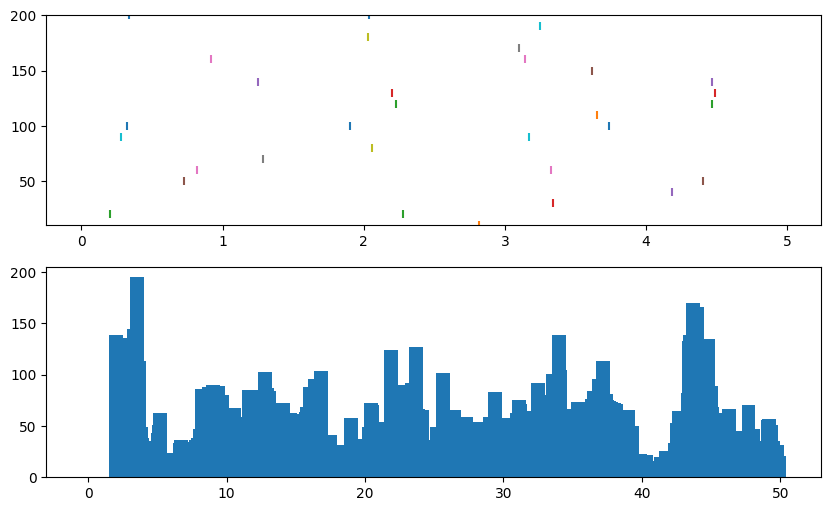

In [6]:
fig,ax=plt.subplots(2,1,figsize=(10,6))
activity3 = actionpot.sum(axis=1)
a=0
b=20000
x = np.arange(potential.shape[0])
for i in np.arange(50):
    ax[0].scatter(x*1e-2,actionpot[a:b,N_e-25+i]*10*i,marker='|')
ax[1].bar(x*1e-1,activity3[a:b],width=1)
ax[0].set_ylim(1*10,20*10)